# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from  torch.optim.lr_scheduler import StepLR

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [11]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            if sheduler: sheduler.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    print_graph(loss_history, train_history, val_history)
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    acc = []
    for x,y in loader:
        prediction = model(x)
        prediction = torch.argmax(prediction, axis=1)
        acc.append((prediction==y).float().sum()/ y.shape[0])
    res = sum(acc)/len(acc)
    return res

def print_graph(loss, train, val):
    fig, axs = plt.subplots(2, figsize=(7,5))
    axs[0].plot(loss, label = 'loss')
    axs[0].legend()
    axs[1].plot(train, label='train acc')
    axs[1].plot(val, label='val acc')
    axs[1].set_xlim(0,1)
    axs[1].legend()

# loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

Average loss: 2.078528, Train accuracy: 0.254667, Val accuracy: 0.357210
Average loss: 1.746153, Train accuracy: 0.401222, Val accuracy: 0.420279
Average loss: 1.659539, Train accuracy: 0.441422, Val accuracy: 0.441391
Average loss: 1.635079, Train accuracy: 0.459390, Val accuracy: 0.460161
Average loss: 1.617795, Train accuracy: 0.467768, Val accuracy: 0.463880


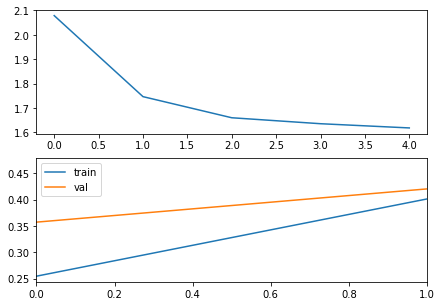

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Добавьте слой с Batch Normalization

Average loss: 1.921701, Train accuracy: 0.380883, Val accuracy: 0.508646
Average loss: 1.464354, Train accuracy: 0.591680, Val accuracy: 0.637654
Average loss: 1.298789, Train accuracy: 0.647664, Val accuracy: 0.659222
Average loss: 1.214410, Train accuracy: 0.676279, Val accuracy: 0.696761
Average loss: 1.163807, Train accuracy: 0.693649, Val accuracy: 0.690267
Average loss: 1.134369, Train accuracy: 0.704894, Val accuracy: 0.720215
Average loss: 1.115222, Train accuracy: 0.716531, Val accuracy: 0.729705
Average loss: 1.105974, Train accuracy: 0.723885, Val accuracy: 0.740344
Average loss: 1.103976, Train accuracy: 0.732143, Val accuracy: 0.736341
Average loss: 1.105101, Train accuracy: 0.733611, Val accuracy: 0.738718
Average loss: 1.109426, Train accuracy: 0.740743, Val accuracy: 0.748554


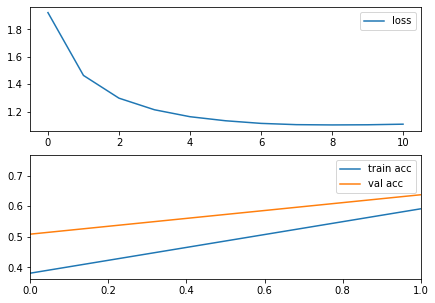

In [99]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 11)

Добавьте уменьшение скорости обучения по ходу тренировки.

Average loss: 2.374659, Train accuracy: 0.108931, Val accuracy: 0.108921
Average loss: 2.370950, Train accuracy: 0.111337, Val accuracy: 0.108000
Average loss: 2.372674, Train accuracy: 0.109477, Val accuracy: 0.108404
Average loss: 2.371641, Train accuracy: 0.109767, Val accuracy: 0.112492
Average loss: 2.371327, Train accuracy: 0.110262, Val accuracy: 0.109285
Average loss: 2.371635, Train accuracy: 0.111337, Val accuracy: 0.108626
Average loss: 2.371953, Train accuracy: 0.110825, Val accuracy: 0.108585
Average loss: 2.372124, Train accuracy: 0.110279, Val accuracy: 0.107766
Average loss: 2.372213, Train accuracy: 0.108999, Val accuracy: 0.108205
Average loss: 2.371750, Train accuracy: 0.110467, Val accuracy: 0.108449


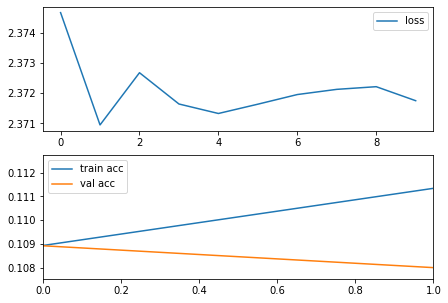

In [110]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
sheduler = StepLR(optimizer, step_size=2, gamma=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=10, sheduler=sheduler)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [68]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    sempler = SubsetSampler(indices)
    val_set = [dataset[i] for i in sempler]
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)
    
    model.eval() # Evaluation mode
    ground_truth = []
    predictions = []
    for x,y in val_loader:
        ground_truth.append(y[0])
        pred = model(x)
        predictions.append(torch.argmax(pred).numpy())
        
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    # raise Exception("Not implemented")
    
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

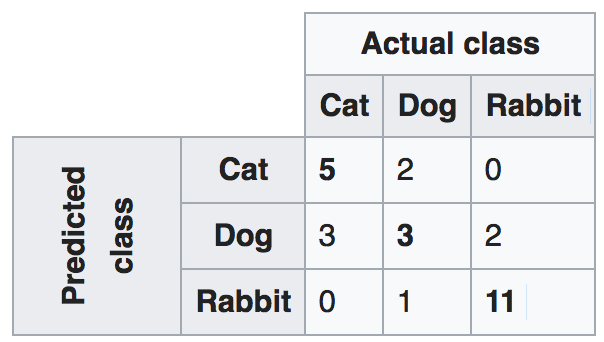

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

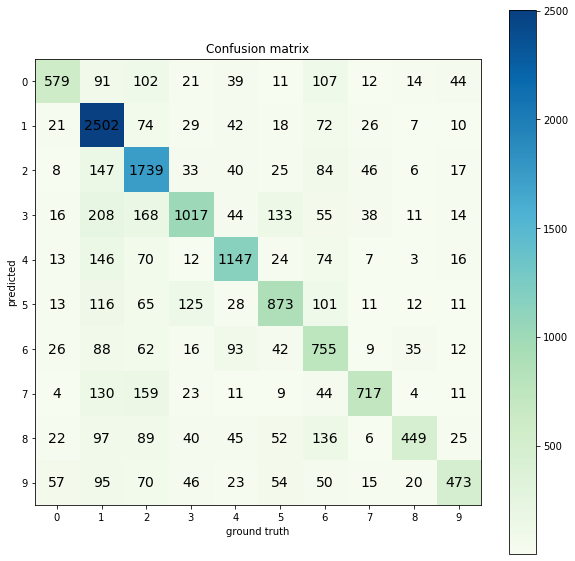

In [97]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    count = lambda x: dict(zip(*np.unique(x, return_counts=True)))
    for p,t in zip(predictions, ground_truth):
        confusion_matrix[t][p]+=1
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

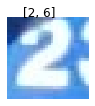

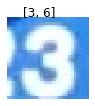

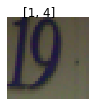

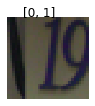

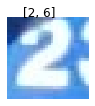

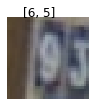

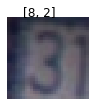

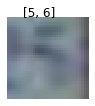

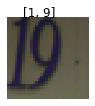

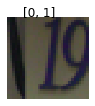

In [94]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")
    indeces = predictions!=groud_truth
    for ind, inc in zip(groud_truth[indeces][:10], predictions[indeces][:10]):
        
        visualize_images([ind], data, [ind,inc])

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
# visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

Average loss: 1.955377, Train accuracy: 0.352404, Val accuracy: 0.549312
Average loss: 1.490650, Train accuracy: 0.576750, Val accuracy: 0.645660
Average loss: 1.301761, Train accuracy: 0.640600, Val accuracy: 0.686844
Average loss: 1.199106, Train accuracy: 0.670136, Val accuracy: 0.677337
Average loss: 1.134834, Train accuracy: 0.690936, Val accuracy: 0.713802
Average loss: 1.091629, Train accuracy: 0.705167, Val accuracy: 0.697261
Average loss: 1.055665, Train accuracy: 0.719756, Val accuracy: 0.749566
Average loss: 1.028207, Train accuracy: 0.731068, Val accuracy: 0.733515
Average loss: 1.007033, Train accuracy: 0.740112, Val accuracy: 0.712267
Average loss: 0.992768, Train accuracy: 0.749753, Val accuracy: 0.747911


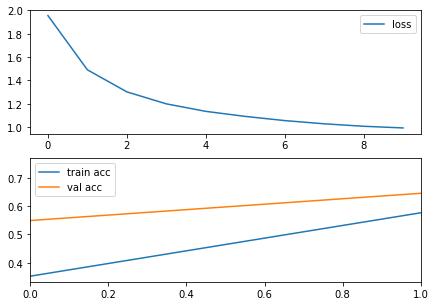

In [125]:
nn_model = nn.Sequential(
            Flattener(),
    
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
    
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
    
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
    
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

In [126]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7106
